# Diamond Price Prediction using Deep Learning

This notebook implements a deep learning model to predict diamond prices based on various features. The implementation is derived from the EDA script but focuses on the regression task.

## Import Required Libraries

Import all necessary Python libraries for data manipulation, visualization, and deep learning.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

## Data Loading Function

Load the diamonds dataset from Seaborn's built-in datasets.

In [4]:
def load_data():
    """Load the diamonds dataset."""
    diamonds = sns.load_dataset('diamonds')
    return diamonds

## Data Information Display Function

Display basic information about the dataset including its structure and summary statistics.

In [5]:
def display_data_info(diamonds):
    """Display information about the dataset."""
    print("\nDataset Info:")
    print(diamonds.info())
    print("\nFirst 5 rows of the dataset:")
    print(diamonds.head())
    
    print("\nBasic Statistics:")
    print(diamonds.describe())

## Categorical Variables Analysis Function

Analyze and visualize the distribution of categorical variables (cut, color, clarity) in the dataset.

In [6]:
def analyze_categorical_variables(diamonds):
    """Analyze categorical variables in the dataset."""
    categorical_cols = ['cut', 'color', 'clarity']
    
    for col in categorical_cols:
        print(f"\n{col.upper()} Distribution:")
        print(diamonds[col].value_counts())
        
        # Create a bar plot
        plt.figure(figsize=(10, 6))
        sns.countplot(data=diamonds, x=col)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## Price Distribution Analysis Function

Analyze and visualize the distribution of diamond prices in the dataset.

In [7]:
def analyze_price_distribution(diamonds):
    """Analyze the distribution of diamond prices."""
    plt.figure(figsize=(12, 6))
    
    # Create a histogram with KDE
    sns.histplot(data=diamonds, x='price', bins=50, kde=True)
    plt.title('Distribution of Diamond Prices')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Print price statistics
    print("\nPrice Statistics:")
    print(diamonds['price'].describe())

## Carat-Price Relationship Analysis Function

Analyze and visualize the relationship between carat and price of diamonds.

In [8]:
def analyze_carat_price_relationship(diamonds):
    """Analyze the relationship between carat and price."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=diamonds, x='carat', y='price', alpha=0.5)
    plt.title('Carat vs Price')
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation = diamonds['carat'].corr(diamonds['price'])
    print(f"\nCorrelation between carat and price: {correlation:.3f}")

## Cut Impact Analysis Function

Analyze how the cut quality affects the price of diamonds.

In [9]:
def analyze_cut_impact(diamonds):
    """Analyze how cut quality affects price."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=diamonds, x='cut', y='price')
    plt.title('Price Distribution by Cut Quality')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print average price by cut
    print("\nAverage Price by Cut:")
    print(diamonds.groupby('cut')['price'].mean().sort_values(ascending=False))

## Correlation Analysis Function

Analyze correlations between numerical variables in the dataset.

In [10]:
def analyze_correlations(diamonds):
    """Analyze correlations between numerical variables."""
    numerical_cols = diamonds.select_dtypes(include=[np.number]).columns
    correlation_matrix = diamonds[numerical_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()

## Model Creation Function

Create and compile the neural network model for price prediction.

In [11]:
def create_model(input_dim):
    """Create and compile the neural network model."""
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

## Data Preparation Function

Prepare the data for model training by handling categorical variables and scaling numerical features.

In [12]:
def prepare_data(diamonds):
    """Prepare the data for model training."""
    # Separate features and target
    X = diamonds.drop('price', axis=1)
    y = diamonds['price']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessing steps
    numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
    categorical_features = ['cut', 'color', 'clarity']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor

## Model Training Function

Train the neural network model on the prepared data.

In [13]:
def train_model(X_train, y_train,patience=10):
    """Train the neural network model."""
    model = create_model(X_train.shape[1])
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    )
    
    return model, history

## Training History Visualization Function

Plot the training history of the model, showing loss and MAE over epochs.

In [14]:
def plot_training_history(history):
    """Plot the training history of the model."""
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Model Evaluation Function

Evaluate the model's performance using various metrics and visualizations.

In [15]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model's performance."""
    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"\nTest MAE: ${test_mae:.2f}")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate R-squared score
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Score: {r2:.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Diamond Prices')
    plt.tight_layout()
    plt.show()

## Load and Display Data

First, let's load the dataset and display its basic information.

In [16]:
# Load the dataset
diamonds = load_data()

# Display basic information
display_data_info(diamonds)




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB
None

First 5 rows of the dataset:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I   

## Explore the Data Analysis

Let's perform a comprehensive EDA on the dataset.


CUT Distribution:
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64


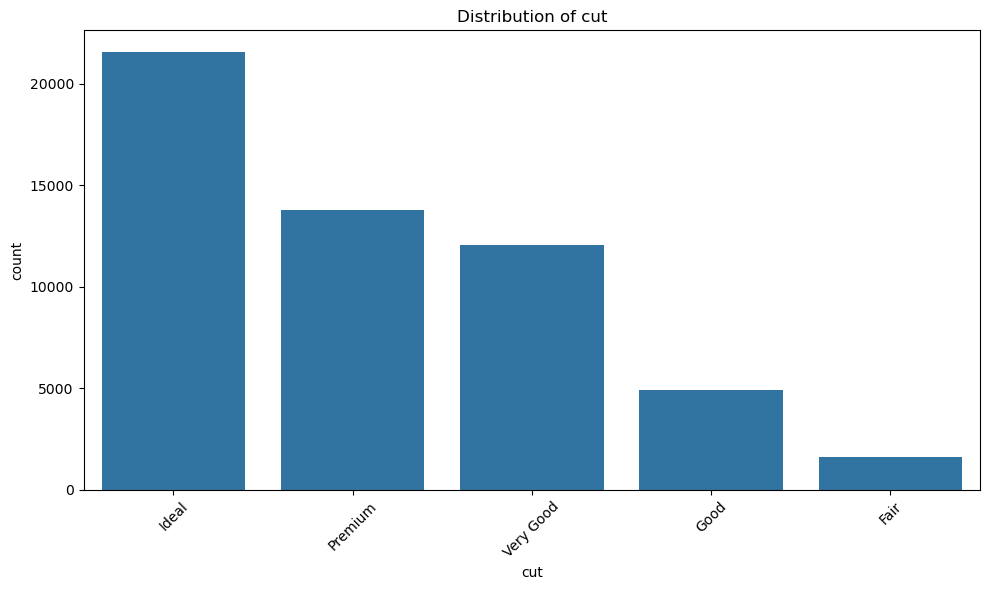


COLOR Distribution:
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64


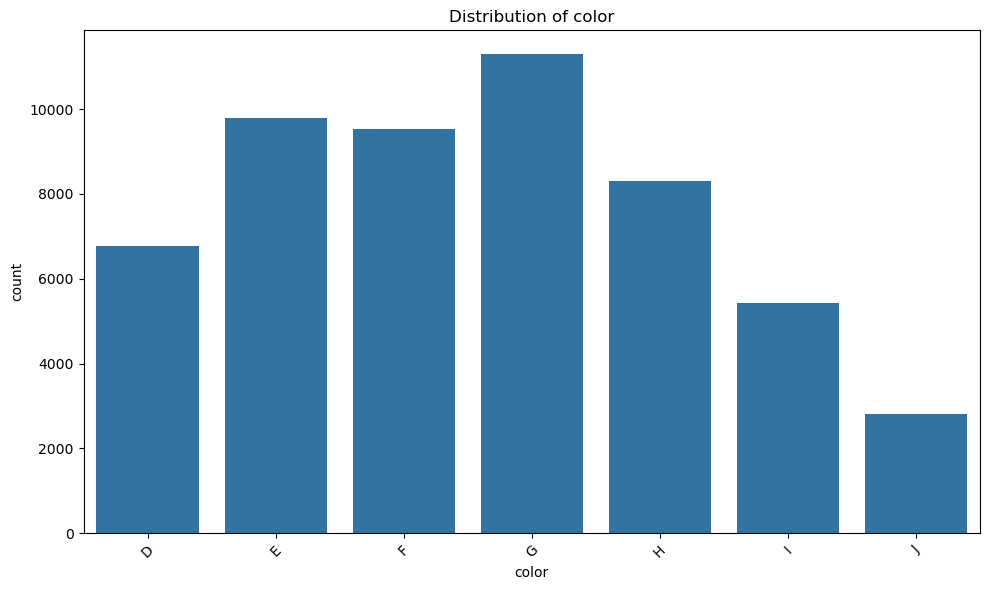


CLARITY Distribution:
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


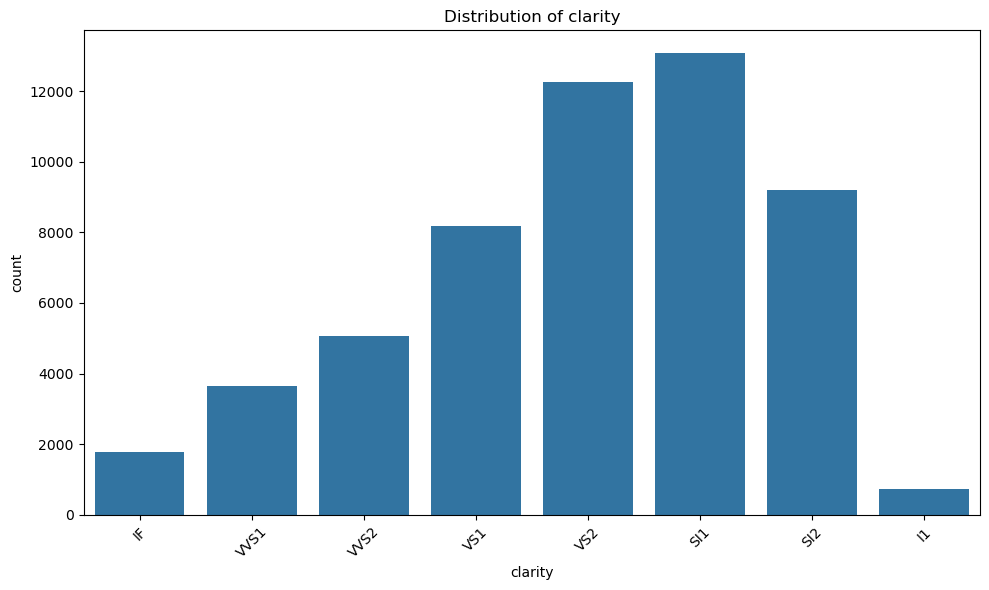

In [17]:
# Analyze categorical variables
analyze_categorical_variables(diamonds)

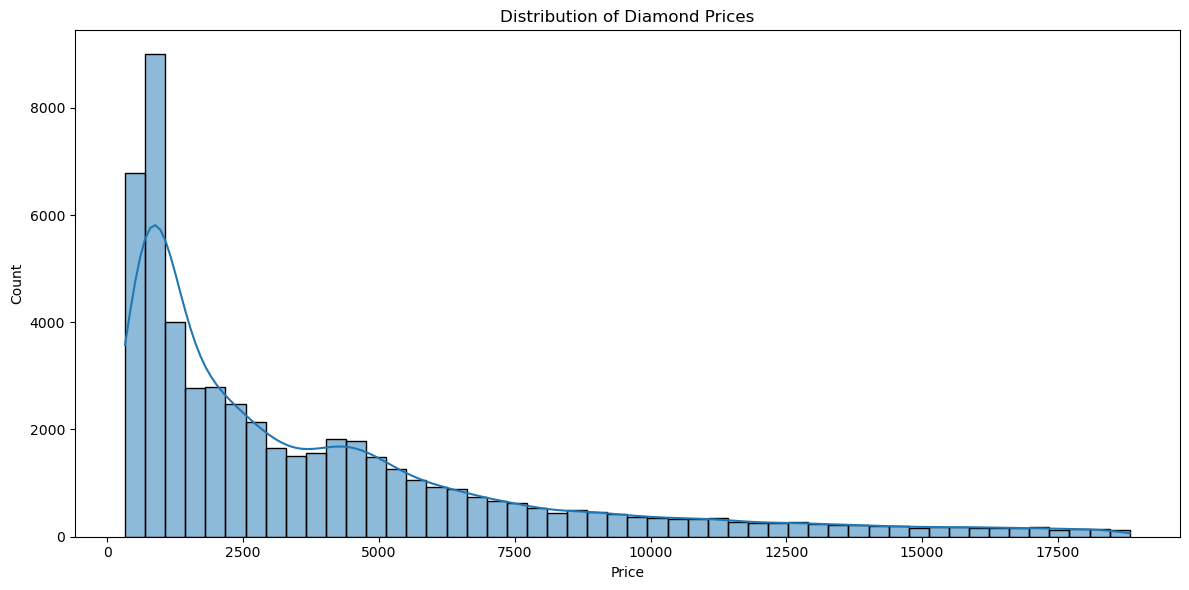


Price Statistics:
count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64


In [18]:
# Analyze price distribution
analyze_price_distribution(diamonds)

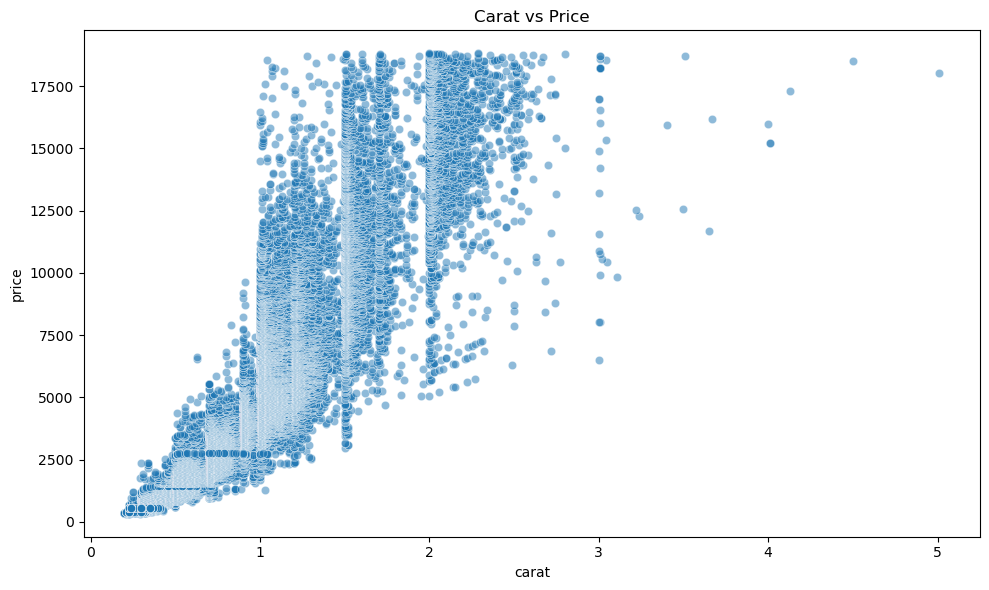


Correlation between carat and price: 0.922


In [19]:
# Analyze carat-price relationship
analyze_carat_price_relationship(diamonds)

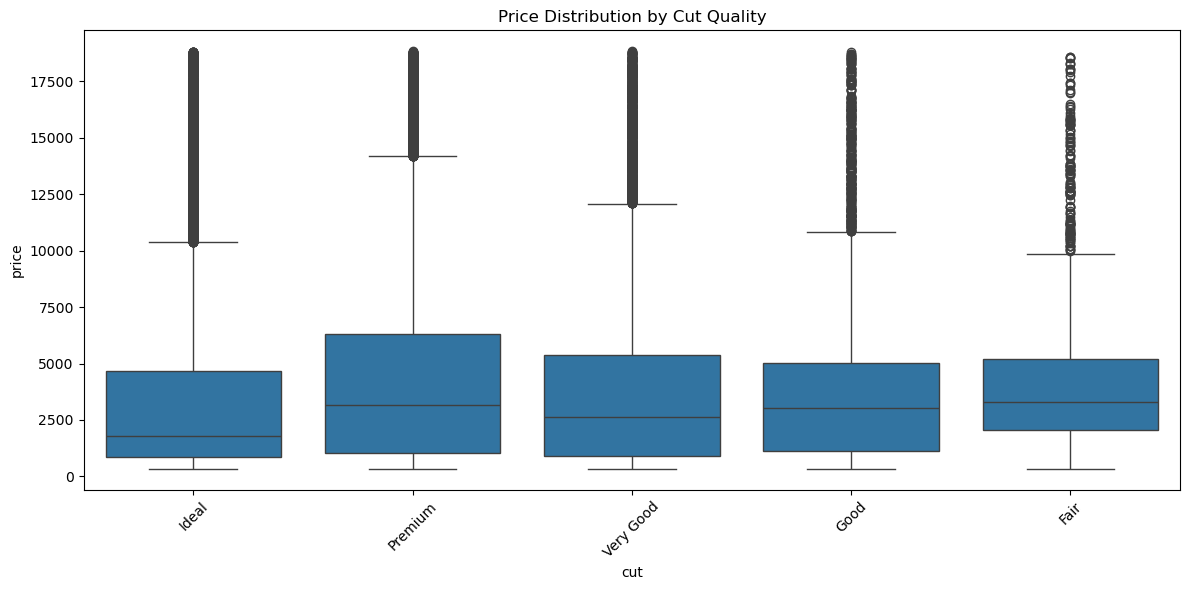


Average Price by Cut:
cut
Premium      4584.257704
Fair         4358.757764
Very Good    3981.759891
Good         3928.864452
Ideal        3457.541970
Name: price, dtype: float64


/var/folders/tn/mbkvm41521gf99q47nglljdr0000gn/T/ipykernel_20505/882933345.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(diamonds.groupby('cut')['price'].mean().sort_values(ascending=False))


In [20]:
# Analyze cut impact on price
analyze_cut_impact(diamonds)

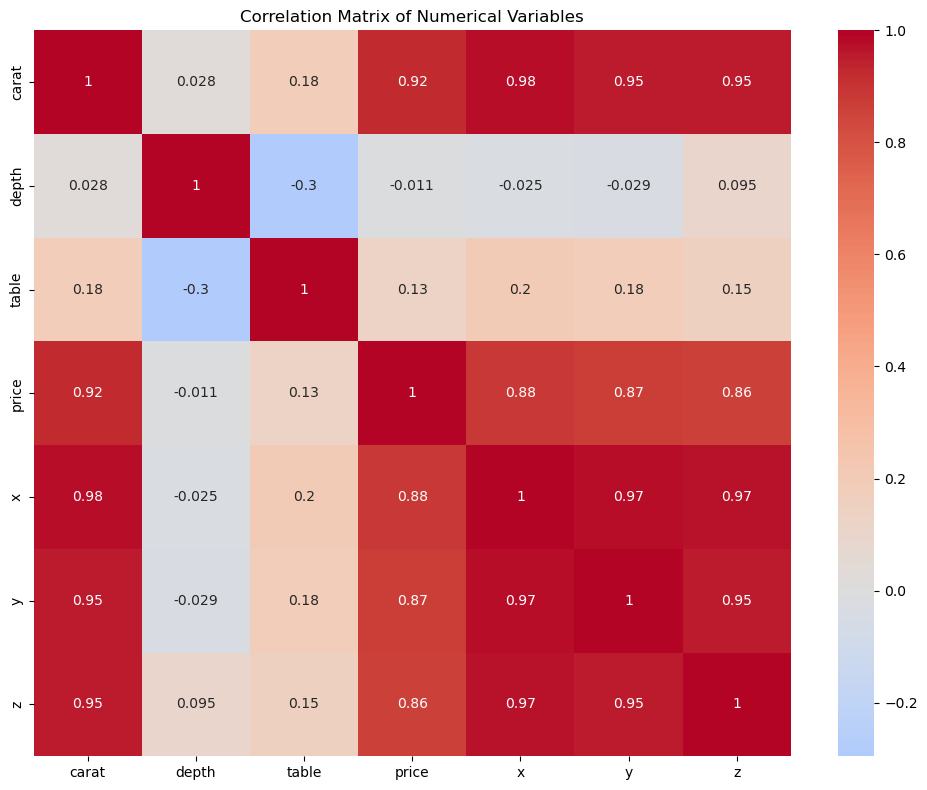

In [21]:
# Analyze correlations
analyze_correlations(diamonds)

## Model Training and Evaluation

Now that we have analyzed the data, let's prepare it for model training and build our deep learning model.

In [25]:
tf.__version__

'2.19.0'

In [28]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [42]:
# Prepare data for model training
X_train, X_test, y_train, y_test, preprocessor = prepare_data(diamonds)

In [ ]:
# Train the model
model, history = train_model(X_train, y_train,patience=5)

Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 13740976.0000 - mae: 2395.6582 - val_loss: 3631673.0000 - val_mae: 1475.9717
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3797405.2500 - mae: 1465.7418 - val_loss: 3272960.5000 - val_mae: 1368.9551
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3275984.7500 - mae: 1337.4612 - val_loss: 2397323.2500 - val_mae: 1134.4166
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 2479186.2500 - mae: 1158.4271 - val_loss: 2562345.0000 - val_mae: 1268.2970
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4372466.5000 - mae: 1600.9329 - val_loss: 2428669.0000 - val_mae: 1167.4546
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 2903379.0000 - mae: 1252.6987 - val_loss: 6439597.0000 - val_mae: 2133.1213
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3187819.5000 - mae: 1268.1704 - val_loss: 2426094.0000 - val_mae: 1183.4044
Epoch 8/50
 637/1079 ━━━━━━━━━━━━

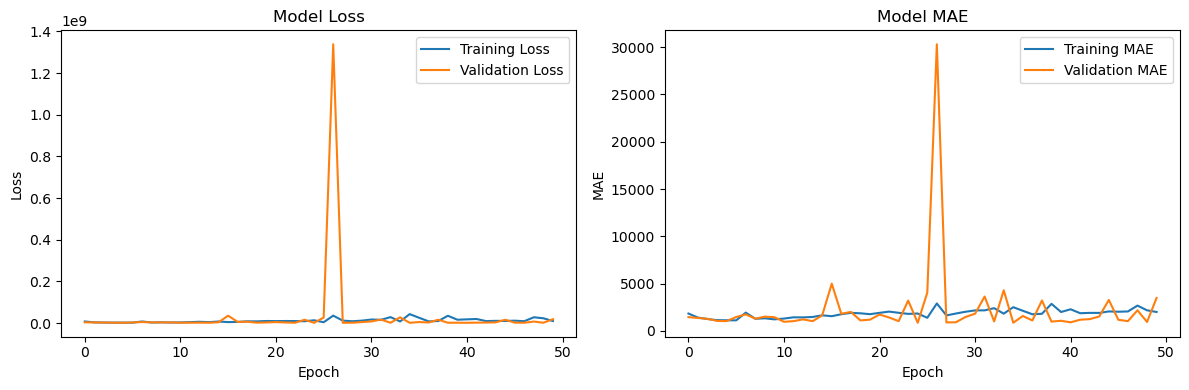

In [ ]:
# Plot training history
plot_training_history(history)

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19361796.0000 - mae: 3540.9788

Test MAE: $3517.11
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
R-squared Score: -0.2012


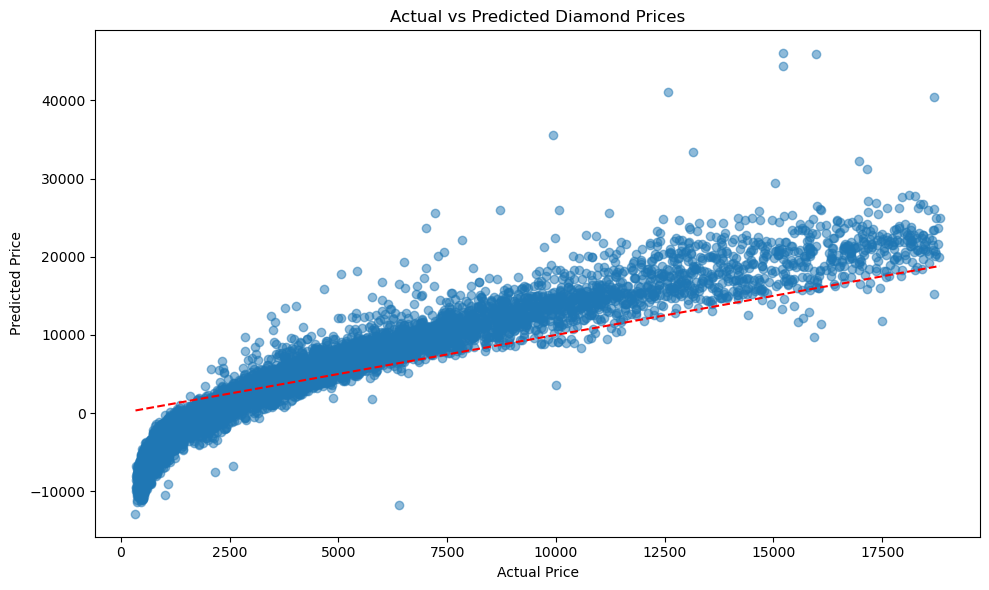

In [ ]:
# Evaluate the model
evaluate_model(model, X_test, y_test)